# Imports

In [63]:
# General Imports
import os
import json
import random
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import torch

# Detectron 2 Libraries
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# Detectron 2 Training Utils
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers
from detectron2.modeling.roi_heads.mask_head import MaskRCNNConvUpsampleHead
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

#Detectron Evaluator
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Utilities

In [64]:
def get_custom_dicts(img_dir):
    """
    Load dataset from JSON annotations and prepare it for Detectron2.
    """
    json_file = os.path.join(img_dir, "annotations.json")  # Adjust if needed
    with open(json_file) as f:
        imgs_anns = json.load(f)  # Load your annotations

    dataset_dicts = []

    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        # Image path and dimensions
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        annos = v.get("regions", v.get("annotations", []))  # Handle different annotation formats

        for anno in annos:
            # Assume each annotation contains shape attributes
            shape_attr = anno["shape_attributes"]
            px = shape_attr["all_points_x"]
            py = shape_attr["all_points_y"]

            # Create segmentation polygon
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,  # Set category ID as per your dataset
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [2]:
def filter_annotations(image_ids):
    """
    # Helper function to filter annotations by image IDs
    """
    images = [img for img in coco_data["images"] if img["id"] in image_ids]
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] in image_ids]
    return {
        "images": images,
        "annotations": annotations,
        "categories": coco_data["categories"]
    }

In [79]:
def visualize_sample_on_axis(dataset_dict, ax, predict_mode=False):
    """
    Visualize a sample image with annotations or predictions on a given axis.
    """
    # Load the image using OpenCV
    img = cv2.imread(dataset_dict["file_name"])
    
    # In predict mode, use predictor; otherwise, visualize annotations
    if predict_mode:
        outputs = predictor(img)
        visualizer = Visualizer(
            img[:, :, ::-1], 
            metadata=my_dataset_metadata, 
            scale=0.5, 
            instance_mode=ColorMode.IMAGE_BW  # Grayscale for unsegmented regions
        )
        vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    else:
        visualizer = Visualizer(
            img[:, :, ::-1], 
            metadata=my_dataset_metadata, 
            scale=0.5
        )
        vis = visualizer.draw_dataset_dict(dataset_dict)

    # Display the image on the axis
    ax.imshow(vis.get_image()[:, :, ::-1])
    ax.axis("off")

In [80]:
# Visualize random samples in the notebook
def visualize_samples(num_samples=3, predict_mode=False):
    """
    Visualize a given number of random samples from the dataset.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, dataset_dict in enumerate(random.sample(dataset_dicts, num_samples)):
        visualize_sample_on_axis(dataset_dict, axes[i], predict_mode)
    plt.tight_layout()
    plt.show()

# Prepare Annotations

In [4]:
# Set paths
images_path = "./dataset/" # Set paths 
annotations_path = "./annotations/MaskRCNN Mining_coco.json" # Set paths

In [5]:
# Load the COCO annotations
with open(annotations_path) as f:
    coco_data = json.load(f)

In [9]:
# Iterate over the annotations and update image dimensions
for entry in coco_data["images"]:
    filename = entry["file_name"]  # Assuming COCO uses 'file_name' key for image paths
    img_path = os.path.join(images_path, filename)

    if os.path.exists(img_path):
        # Read image using OpenCV
        img = cv2.imread(img_path)
        if img is not None:
            height, width = img.shape[:2]

            # Update the image entry with the correct dimensions
            entry["width"] = width
            entry["height"] = height
        else:
            print(f"Error: Unable to read image {filename}.")
    else:
        print(f"Warning: Image {filename} not found.")

In [13]:
# Save the updated annotations back to the JSON file
with open(annotations_path, "w") as f:
    json.dump(coco_data, f, indent=4)

print("Annotations updated successfully!")

Annotations updated successfully!


In [14]:
# Extract image IDs and shuffle
image_ids = [img["id"] for img in coco_data["images"]]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

In [15]:
# Create separate JSON files for train and validation
train_data = filter_annotations(train_ids)
test_data = filter_annotations(test_ids)

In [16]:
# Save the split annotations
with open("./annotations/train_annotations.json", "w") as f:
    json.dump(train_data, f)

with open("./annotations/test_annotations.json", "w") as f:
    json.dump(test_data, f)

# Register Dataset in Detectron2

In [70]:
# Clear previous registrations (if they exist)
for dataset_name in ["mine_train", "mine_test"]:
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)

In [71]:
# Register the train and validation datasets
register_coco_instances("mine_train", {}, "./annotations/train_annotations.json", images_path)
register_coco_instances("mine_test", {}, "./annotations/test_annotations.json", images_path)

In [82]:
my_dataset_metadata = MetadataCatalog.get("mine_train")
dataset_dicts = DatasetCatalog.get("mine_train")

[10/18 16:30:26 d2.data.datasets.coco]: Loaded 105 images in COCO format from ./annotations/train_annotations.json


## Visualize Images

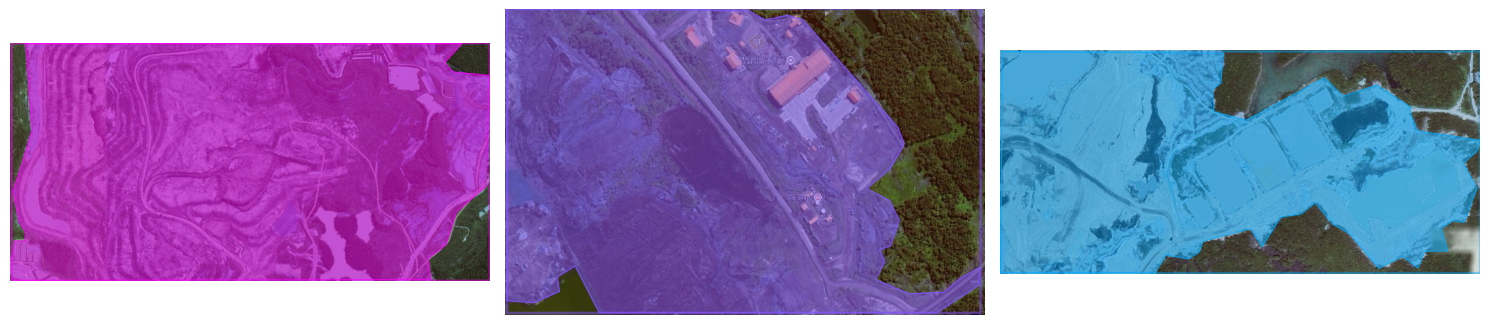

In [89]:
visualize_samples(num_samples=3, predict_mode=False)  # Set predict_mode=True for predictions

# Training

In [117]:
# Configuration setup
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Paths for datasets
cfg.DATASETS.TRAIN = ("mine_train",)
cfg.DATASETS.TEST = ("mine_test",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [118]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[10/18 16:47:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [119]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18912), started 0:40:34 ago. (Use '!kill 18912' to kill it.)

# Inference and Evaluation

In [124]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/18 16:57:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


## Visualize the segmentation

In [125]:
# Load your dataset and metadata
dataset_dicts = DatasetCatalog.get("mine_test")
mine_metadata = MetadataCatalog.get("mine_test")  # Get metadata for your dataset

[10/18 16:57:29 d2.data.datasets.coco]: Loaded 27 images in COCO format from ./annotations/test_annotations.json


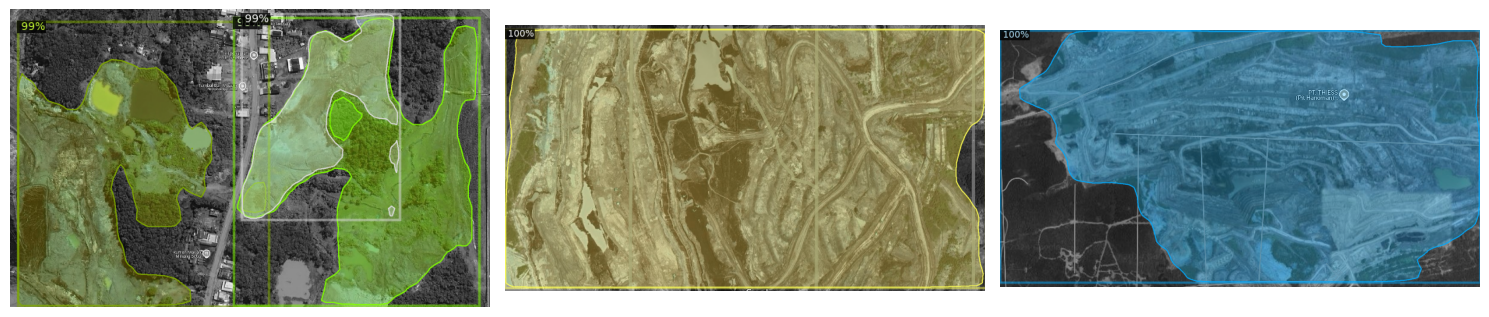

In [126]:
visualize_samples(num_samples=3, predict_mode=True)  # Set predict_mode=True for predictions

## AP Metric Evaluation

In [123]:
evaluator = COCOEvaluator("mine_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "mine_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/18 16:52:39 d2.data.datasets.coco]: Loaded 27 images in COCO format from ./annotations/test_annotations.json
[10/18 16:52:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/18 16:52:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/18 16:52:39 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[10/18 16:52:39 d2.data.common]: Serialized dataset takes 0.01 MiB
[10/18 16:52:39 d2.evaluation.evaluator]: Start inference on 27 batches
[10/18 16:52:43 d2.evaluation.evaluator]: Inference done 11/27. Dataloading: 0.0006 s/iter. Inference: 0.0636 s/iter. Eval: 0.0071 s/iter. Total: 0.0713 s/iter. ETA=0:00:01
[10/18 16:52:44 d2.evaluation.evaluator]: Total inference time: 0:00:01.927865 (0.087630 s / iter per device, on 1 devices)
[10/18 16:52:44 d2.evaluation.evaluator]: Total in

- AP: Overall model average precision.
- AP50: Overall Precision at IoU 0.5
- AP75: Overall Precision at IoU 0.75
- APs, APm: These are NaN because there are no small or medium objects.
- APl: Large objects AP.
- AP-: Aggregated or weighted AP